In [1]:
#import packages
import isotopylog as ipl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy.optimize import curve_fit
from numpy.polynomial import Polynomial
from scipy.optimize import fsolve, minimize

# 读取CSV文件
df = pd.read_excel('./datasets/ThermalHis.xlsx')

# 提取四个变量
time = df['Time/Myr'].values
top_temp = df['Top_T/Celsius'].values + 273.15
#min_temp = df['Min_T/Celsius'].values + 273.15
#max_temp = df['Max_T/Celsius'].values + 273.15

# 查看提取的变量
print(time[:5], top_temp[:5])

[254.1  253.75 253.4  253.05 252.7 ] [293.15 293.15 293.15 293.15 293.15]


In [2]:
# 读取CSV文件
df_test = pd.read_excel('./datasets/delta_47.xlsx')

# 提取四个变量
delta47 = df_test['Delta47'].values
delta47_err = df_test['SD'].values

# 查看提取的变量
print(delta47[:5], delta47_err[:5])

[0.41165162 0.39991129 0.47928827 0.46105086 0.47292379] [0.036864 0.02092  0.032898 0.017926 0.036896]


In [3]:
#generate EDistribution instance from literature
ed = ipl.EDistribution.from_literature(
        mineral = 'dolomite',
        reference = 'HH21')

#define the initial composition and the time-temperature evolutions
d0_std = [0.02]

#T = top_temp[::-1]
T = top_temp
#make D0 in equilibrium
D0 = ipl.Deq_from_T(T[0])
d0 = [D0, 0, 0] #still d13C and d18O of zero

tSecond = time * 1e6 * 365 * 24 * 60 *60 #convert Myr to seconds
tSecond = tSecond[::-1]
#tSecond = tSecond[0] - tSecond
#tmyr =  time[::-1]#原始时间尺度为Myr

tmyr =  time#原始时间尺度为My

#now calculate D at each time point
D, Dstd = ipl.geologic_history(tSecond, T, ed, d0, d0_std = d0_std)

#plot results, along with equilibrium D at each time point
Deq = ipl.Deq_from_T(T)

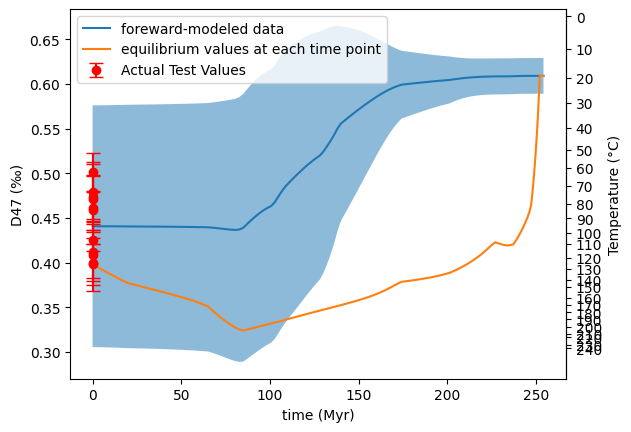

In [4]:
fig,ax = plt.subplots(1,1)

# 添加右边的 y 轴，直接用指定范围转化温度
temp_range = np.linspace(0.3, 0.7, 100)  # 定义 Δ47 范围
temp_values = [ipl.T_from_Deq(delta) - 273.5 for delta in temp_range]  # 转换为温度
temp_ticks = np.arange(0, max(temp_values), 10)  # 从 0 开始，每隔 10
temp_tick_labels = [f"{int(t)}" for t in temp_ticks]  # 转为整数标签

secax = ax.secondary_yaxis('right')
secax.set_yticks([temp_range[np.abs(temp_values - t).argmin()] for t in temp_ticks])
secax.set_yticklabels(temp_tick_labels)
secax.set_ylabel('Temperature (°C)')

ax.plot(tmyr, D, label = 'foreward-modeled data')
ax.fill_between(tmyr, D - Dstd, D + Dstd, alpha = 0.5)
ax.errorbar([0] * len(delta47), delta47, yerr=delta47_err, fmt='o', label='Actual Test Values', color='red', capsize=5)
ax.plot(tmyr,Deq, label = 'equilibrium values at each time point')

ax.set_xlabel('time (Myr)')
ax.set_ylabel('D47 (‰)')
ax.legend(loc = 'best')

In [5]:
file_path = './datasets/delta_47.xlsx'  # 替换为你的文件路径
df = pd.read_excel(file_path, sheet_name='Sheet1')

# 删除重复表头（如果存在）
df = df[df['ID'] != 'ID']

# 确保 age 列为数值类型，非数值的会被转换为 NaN
df['age'] = pd.to_numeric(df['age'], errors='coerce')

# 分离方解石和白云石
calcite_df = df[df['Lith'] == 'Calcite']
dolomite_df = df[df['Lith'] == 'Dolomite']

# 打印结果
print("方解石（Calcite）有年龄的数据：")
print(calcite_df)

print("\n白云石（Dolomite）有年龄的数据：")
print(dolomite_df)

方解石（Calcite）有年龄的数据：
           ID     Lith   Detail   Delta47        SD    age  age_err
0   202504762  Calcite  细-中晶方解石  0.411652  0.036864  255.0     13.4
1   202504763  Calcite    板状方解石  0.399911  0.020920  251.8      2.4
6   202504767  Calcite    粗晶方解石  0.398060  0.029894  172.3      8.9
7   202504768  Calcite  细-中晶方解石  0.424830  0.011954  255.0     13.4
10  202504770  Calcite       灰岩  0.408800  0.025924  269.2      2.5

白云石（Dolomite）有年龄的数据：
          ID      Lith   Detail   Delta47        SD    age  age_err
2  202504764  Dolomite  中-粗晶白云岩  0.479288  0.032898    NaN      NaN
3  202504765  Dolomite    粉晶白云岩  0.461051  0.017926    NaN      NaN
4  202504765  Dolomite    粉晶白云岩  0.472924  0.036896    NaN      NaN
5  202504766  Dolomite    鞍型白云石  0.459174  0.038854  252.3      2.7
8  202504769  Dolomite    细晶白云岩  0.501245  0.020884    NaN      NaN
9  202504769  Dolomite    细晶白云岩  0.471044  0.025892    NaN      NaN


In [6]:
# 提取变量
delta47_dol = dolomite_df['Delta47'].values
delta47_dol_err = dolomite_df['SD'].values

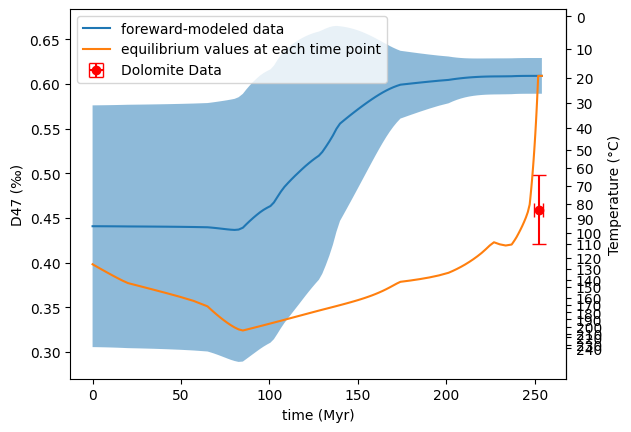

In [7]:
fig,ax = plt.subplots(1,1)

# 添加右边的 y 轴，直接用指定范围转化温度
temp_range = np.linspace(0.3, 0.7, 100)  # 定义 Δ47 范围
temp_values = [ipl.T_from_Deq(delta) - 273.5 for delta in temp_range]  # 转换为温度
temp_ticks = np.arange(0, max(temp_values), 10)  # 从 0 开始，每隔 10
temp_tick_labels = [f"{int(t)}" for t in temp_ticks]  # 转为整数标签

secax = ax.secondary_yaxis('right')
secax.set_yticks([temp_range[np.abs(temp_values - t).argmin()] for t in temp_ticks])
secax.set_yticklabels(temp_tick_labels)
secax.set_ylabel('Temperature (°C)')

ax.plot(tmyr, D, label = 'foreward-modeled data')
ax.fill_between(tmyr, D - Dstd, D + Dstd, alpha = 0.5)
ax.errorbar(dolomite_df['age'], dolomite_df['Delta47'],
            yerr=dolomite_df['SD'],
            xerr=dolomite_df['age_err'],
            fmt='o', color='red', capsize=5, label='Dolomite Data')
ax.plot(tmyr,Deq, label = 'equilibrium values at each time point')

ax.set_xlabel('time (Myr)')
ax.set_ylabel('D47 (‰)')
ax.legend(loc = 'best')

plt.savefig('ini_20_dol.svg')

In [8]:
#generate EDistribution instance from literature
ed = ipl.EDistribution.from_literature(
        mineral = 'calcite',
        reference = 'HH21')

#define the initial composition and the time-temperature evolutions
d0_std = [0.02]

#T = top_temp[::-1]
T = top_temp
#make D0 in equilibrium
D0 = ipl.Deq_from_T(T[0])
d0 = [D0, 0, 0] #still d13C and d18O of zero

tSecond = time * 1e6 * 365 * 24 * 60 *60 #convert Myr to seconds
tSecond = tSecond[::-1]
#tSecond = tSecond[0] - tSecond
#tmyr =  time[::-1]#原始时间尺度为Myr

tmyr =  time#原始时间尺度为My

#now calculate D at each time point
D, Dstd = ipl.geologic_history(tSecond, T, ed, d0, d0_std = d0_std)

#plot results, along with equilibrium D at each time point
Deq = ipl.Deq_from_T(T)

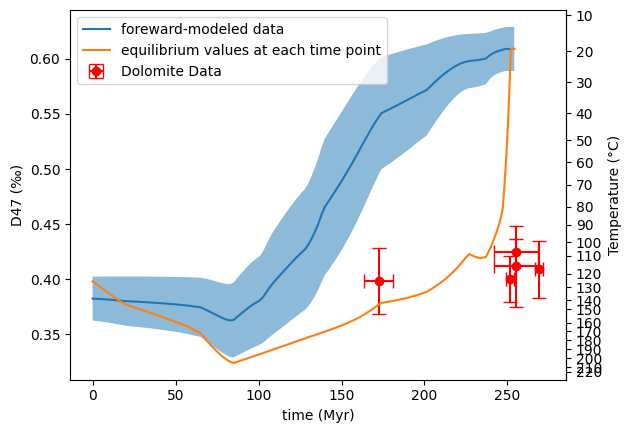

In [9]:
fig,ax = plt.subplots(1,1)

# 添加右边的 y 轴，直接用指定范围转化温度
temp_range = np.linspace(0.3, 0.7, 100)  # 定义 Δ47 范围
temp_values = [ipl.T_from_Deq(delta) - 273.5 for delta in temp_range]  # 转换为温度
temp_ticks = np.arange(0, max(temp_values), 10)  # 从 0 开始，每隔 10
temp_tick_labels = [f"{int(t)}" for t in temp_ticks]  # 转为整数标签

secax = ax.secondary_yaxis('right')
secax.set_yticks([temp_range[np.abs(temp_values - t).argmin()] for t in temp_ticks])
secax.set_yticklabels(temp_tick_labels)
secax.set_ylabel('Temperature (°C)')

ax.plot(tmyr, D, label = 'foreward-modeled data')
ax.fill_between(tmyr, D - Dstd, D + Dstd, alpha = 0.5)
ax.errorbar(calcite_df['age'], calcite_df['Delta47'],
            yerr=calcite_df['SD'],
            xerr=calcite_df['age_err'],
            fmt='o', color='red', capsize=5, label='Dolomite Data')
ax.plot(tmyr,Deq, label = 'equilibrium values at each time point')

ax.set_xlabel('time (Myr)')
ax.set_ylabel('D47 (‰)')
ax.legend(loc = 'best')

plt.savefig('ini_20_cal.svg')

In [10]:
# 读取CSV文件
df = pd.read_excel('./datasets/ThermalHis_Dol.xlsx')

# 提取四个变量
time = df['Time/Myr'].values
top_temp = df['Top_T/Celsius'].values + 273.15
#min_temp = df['Min_T/Celsius'].values + 273.15
#max_temp = df['Max_T/Celsius'].values + 273.15

# 查看提取的变量
print(time[:5], top_temp[:5])

[254.1  253.75 253.4  253.05 252.7 ] [353.15 353.15 353.15 353.15 353.15]


In [11]:
#generate EDistribution instance from literature
ed = ipl.EDistribution.from_literature(
        mineral = 'dolomite',
        reference = 'HH21')

#define the initial composition and the time-temperature evolutions
d0_std = [0.02]

#T = top_temp[::-1]
T = top_temp
#make D0 in equilibrium
D0 = ipl.Deq_from_T(T[0])
d0 = [D0, 0, 0] #still d13C and d18O of zero

tSecond = time * 1e6 * 365 * 24 * 60 *60 #convert Myr to seconds
tSecond = tSecond[::-1]
#tSecond = tSecond[0] - tSecond
#tmyr =  time[::-1]#原始时间尺度为Myr

tmyr =  time#原始时间尺度为My

#now calculate D at each time point
D, Dstd = ipl.geologic_history(tSecond, T, ed, d0, d0_std = d0_std)

#plot results, along with equilibrium D at each time point
Deq = ipl.Deq_from_T(T)

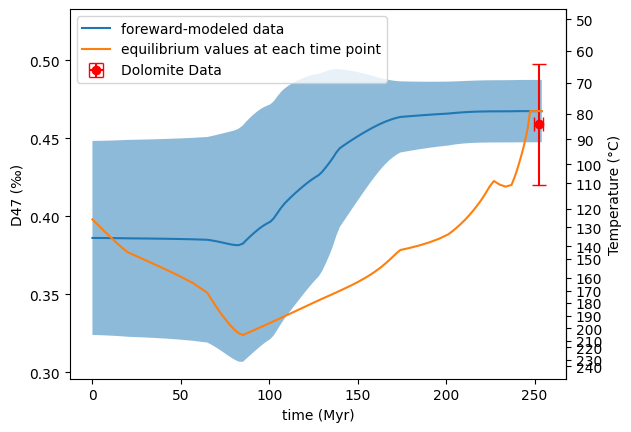

In [12]:
fig,ax = plt.subplots(1,1)

# 添加右边的 y 轴，直接用指定范围转化温度
temp_range = np.linspace(0.3, 0.7, 100)  # 定义 Δ47 范围
temp_values = [ipl.T_from_Deq(delta) - 273.5 for delta in temp_range]  # 转换为温度
temp_ticks = np.arange(0, max(temp_values), 10)  # 从 0 开始，每隔 10
temp_tick_labels = [f"{int(t)}" for t in temp_ticks]  # 转为整数标签

secax = ax.secondary_yaxis('right')
secax.set_yticks([temp_range[np.abs(temp_values - t).argmin()] for t in temp_ticks])
secax.set_yticklabels(temp_tick_labels)
secax.set_ylabel('Temperature (°C)')

ax.plot(tmyr, D, label = 'foreward-modeled data')
ax.fill_between(tmyr, D - Dstd, D + Dstd, alpha = 0.5)
ax.errorbar(dolomite_df['age'], dolomite_df['Delta47'],
            yerr=dolomite_df['SD'],
            xerr=dolomite_df['age_err'],
            fmt='o', color='red', capsize=5, label='Dolomite Data')
ax.plot(tmyr,Deq, label = 'equilibrium values at each time point')

ax.set_xlabel('time (Myr)')
ax.set_ylabel('D47 (‰)')
ax.legend(loc = 'best')

plt.savefig('ini_80_dol.svg')